In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import Tokenizer, StopWordsRemover
spark = SparkSession.builder.appName("Uber Reviews").getOrCreate()


In [5]:
################
##Data Loading##
################
df_original = spark.read.csv("Uber_Ride_Reviews.csv", header=True, inferSchema=True)
df_original.show()


+--------------------+-----------+---------+
|         ride_review|ride_rating|sentiment|
+--------------------+-----------+---------+
|I completed runni...|        1.0|        0|
|My appointment ti...|        1.0|        0|
|Whether I using U...|        1.0|        0|
|Why hard understa...|        1.0|        0|
|I South Beach FL ...|        1.0|        0|
|I damage vehicle ...|        1.0|        0|
|I use Uber fairly...|        2.0|        0|
|Last night I retu...|        1.0|        0|
|Do lose anything ...|        1.0|        0|
|My last experienc...|        1.0|        0|
|Our party consist...|        1.0|        0|
|time I extremely ...|        3.0|        1|
|I file class acti...|        1.0|        0|
|If I give stars I...|        1.0|        0|
|I driven KCVG lea...|        1.0|        0|
|I used many times...|        1.0|        0|
|It unfortunate kn...|        2.0|        0|
|DO NOT ACCEPT RID...|        1.0|        0|
|I purchased dolla...|        1.0|        0|
|We used U

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=23c1900ebca9734e20dab7c9c835d4ddfb4fc00e5bd9373862e678c98fbf941b
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [6]:
#################
##Data cleaning##
#################

#removing netural(3) rating records from the dataset
df_clean = df_original.filter(df_original.ride_rating != 3)

#tokenization
tokenizer = Tokenizer(inputCol="ride_review", outputCol="ride_review_tokens")
df_clean = tokenizer.transform(df_clean)


#remove custom stop words
stop_words = ['ourselves', 'hers', 'between', 'yourself', 'driver', 'uber', 'again', 'there',
              'about', 'once', 'during', 'very', 'having', 'with', 'they', 'own', 'an', 'be',
              'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'itself', 'other',
              'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves',
              'until', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me',
              'were', 'her', 'more', 'himself', 'this', 'should', 'our', 'their', 'while',
              'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'when', 'at', 'any', 'before',
              'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves',
              'then', 'that', 'because', 'what', 'why', 'so', 'can', 'now', 'he', 'you', 'herself',
              'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'whom',
              'being', 'if', 'theirs', 'my', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here']

stop_words_remover = StopWordsRemover(inputCol='ride_review_tokens', outputCol='ride_review_clean', stopWords=stop_words)
df_clean = stop_words_remover.transform(df_clean)
df_clean.show()
df_clean.summary().show()

+--------------------+-----------+---------+--------------------+--------------------+
|         ride_review|ride_rating|sentiment|  ride_review_tokens|   ride_review_clean|
+--------------------+-----------+---------+--------------------+--------------------+
|I completed runni...|        1.0|        0|[i, completed, ru...|[completed, runni...|
|My appointment ti...|        1.0|        0|[my, appointment,...|[appointment, tim...|
|Whether I using U...|        1.0|        0|[whether, i, usin...|[whether, using, ...|
|Why hard understa...|        1.0|        0|[why, hard, under...|[hard, understand...|
|I South Beach FL ...|        1.0|        0|[i, south, beach,...|[south, beach, fl...|
|I damage vehicle ...|        1.0|        0|[i, damage, vehic...|[damage, vehicle,...|
|I use Uber fairly...|        2.0|        0|[i, use, uber, fa...|[use, fairly, fre...|
|Last night I retu...|        1.0|        0|[last, night, i, ...|[last, night, ret...|
|Do lose anything ...|        1.0|        0

In [7]:
#converting list of strings of a review to list of integers based on frequency of each word in the corpus(total reviews)
cv = CountVectorizer(inputCol="ride_review_clean", outputCol="features")
cv_model = cv.fit(df_clean)
cv_train_df = cv_model.transform(df_clean)
cv_train_df.show()

#split train and test data
train, test = cv_train_df.randomSplit([0.7, 0.3])

+--------------------+-----------+---------+--------------------+--------------------+--------------------+
|         ride_review|ride_rating|sentiment|  ride_review_tokens|   ride_review_clean|            features|
+--------------------+-----------+---------+--------------------+--------------------+--------------------+
|I completed runni...|        1.0|        0|[i, completed, ru...|[completed, runni...|(7559,[0,1,2,3,4,...|
|My appointment ti...|        1.0|        0|[my, appointment,...|[appointment, tim...|(7559,[1,3,5,11,1...|
|Whether I using U...|        1.0|        0|[whether, i, usin...|[whether, using, ...|(7559,[1,3,4,5,6,...|
|Why hard understa...|        1.0|        0|[why, hard, under...|[hard, understand...|(7559,[9,22,31,33...|
|I South Beach FL ...|        1.0|        0|[i, south, beach,...|[south, beach, fl...|(7559,[2,3,6,8,9,...|
|I damage vehicle ...|        1.0|        0|[i, damage, vehic...|[damage, vehicle,...|(7559,[0,22,46,68...|
|I use Uber fairly...|      

In [8]:
#train Logistic Regression model
lr = LogisticRegression(featuresCol='features', labelCol='sentiment')
lrModel = lr.fit(train)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))


Coefficients: [-0.42076091319666226,-0.4811561844823458,0.16288539568628105,0.319814365371883,0.6583163385887157,0.35789985099755306,-1.9130608992330203,-1.8737427583098203,-0.5306438154801983,-0.615168113908031,-0.3914509114906062,0.04738015431350985,0.15763295776302766,-0.3224611170526826,-0.4883540829101083,0.4312133919403329,-0.6210244878961406,-0.3159079886530188,-0.5820595192089075,-0.2642458362264097,-0.7558793273610167,-0.13655484271033094,-0.3716201471009528,-0.8939385388612198,-0.9864429196565493,-0.4670206308981858,-0.533627131340212,-0.44726540165413853,0.5923809513501073,-0.01318472302253874,0.5468675492395306,0.04622949554709206,1.5988915883680324,-0.92886107954532,-0.38902475997459607,-0.32466739755149493,-0.6313837888237822,-0.13573522044445843,-0.38519764850902155,-0.3835574768163442,0.8959407082024219,-0.018917555926336465,-0.8991516107650289,-0.9819023299535955,-0.28927108268478335,0.7205315506327787,2.8380633143167033,-0.9103416582889449,0.20239167596527763,-0.67367

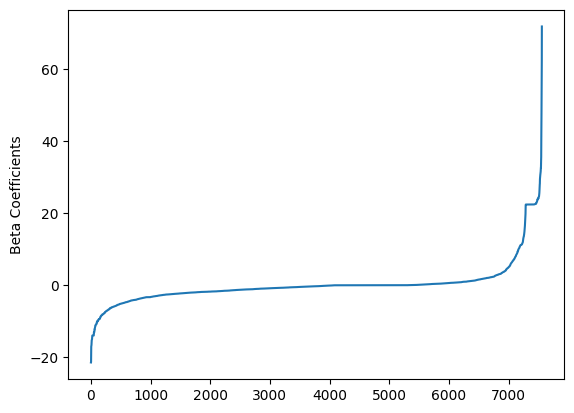

In [9]:
beta = np.sort(lrModel.coefficients)

plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [10]:
#prediction
predict_test=lrModel.transform(test)
predict_test.select("ride_review_clean", 'sentiment', 'prediction', 'ride_rating').show()

+--------------------+---------+----------+-----------+
|   ride_review_clean|sentiment|prediction|ride_rating|
+--------------------+---------+----------+-----------+
|[week, ago, tried...|        0|       0.0|        1.0|
|[awful, experienc...|        0|       0.0|        1.0|
|[credit, card, in...|        0|       0.0|        1.0|
|[must, put, side,...|        0|       0.0|        1.0|
|[night, got, taxi...|        0|       0.0|        1.0|
|[night, one, week...|        0|       0.0|        1.0|
|[seeing, many, pr...|        0|       0.0|        1.0|
|[signing, tried, ...|        0|       0.0|        1.0|
|[app, login, issu...|        0|       0.0|        1.0|
|[app, showing, ca...|        0|       0.0|        1.0|
|[app, works, fine...|        1|       0.0|        4.0|
|[frustrating, ele...|        0|       1.0|        2.0|
|[transportation, ...|        1|       1.0|        4.0|
|[asked, suppose, ...|        0|       0.0|        1.0|
|[comparing, airli...|        0|       1.0|     

In [11]:
#Words and their respective coef
df = pd.DataFrame({'Word':cv_model.vocabulary, 'Coef': lrModel.coefficients})
df.sort_values('Coef').head(20)

,Word,Coef
3294,bed,-21.394282
6400,groupon,-21.296553
3135,capable,-21.268135
4272,paytip,-18.391677
4441,daunting,-17.625792
4460,laugh,-16.968406
6526,bastard,-16.868546
5441,bwa,-16.851884
7285,preposterous,-16.830288
6769,jacking,-16.548731


In [12]:
#Inspect tool
predict_test.filter(predict_test['prediction'] == 1) \
    .select("sentiment","ride_rating","probability","prediction", "ride_review") \
    .orderBy("probability", ascending=False) \
    .show(n = 50, truncate = 50)

+---------+-----------+------------------------------------------+----------+--------------------------------------------------+
|sentiment|ride_rating|                               probability|prediction|                                       ride_review|
+---------+-----------+------------------------------------------+----------+--------------------------------------------------+
|        1|        5.0|   [0.4781114759511311,0.5218885240488689]|       1.0|I using random uber ride year Mostly get drunk ...|
|        0|        2.0|  [0.47470949443113286,0.5252905055688671]|       1.0|I using uber year Never got disappointed Now ub...|
|        0|        1.0|   [0.4563793637056725,0.5436206362943274]|       1.0|Have driving uber weeks take almost half fare c...|
|        0|        1.0|   [0.4236568871217402,0.5763431128782598]|       1.0|I live Las Vegas NV experience one drivers tail...|
|        0|        1.0|  [0.40831079550163835,0.5916892044983617]|       1.0|You ca pay cash Uber

+---------+----------+-------------------------------------------+
|sentiment|prediction|probability                                |
+---------+----------+-------------------------------------------+
|0        |0.0       |[0.9999999657688193,3.4231180667809724E-8] |
|0        |0.0       |[0.9999972040758177,2.795924182286136E-6]  |
|0        |0.0       |[0.9999999808449166,1.915508340832872E-8]  |
|0        |0.0       |[0.9430665879052758,0.056933412094724245]  |
|0        |0.0       |[0.999999998883881,1.116118975019731E-9]   |
|0        |0.0       |[0.9999999935928314,6.407168573474564E-9]  |
|0        |0.0       |[1.0,0.0]                                  |
|0        |0.0       |[0.9906454739926419,0.009354526007358088]  |
|0        |0.0       |[0.999984198638951,1.580136104895047E-5]   |
|0        |0.0       |[0.9999999941948579,5.805142144765796E-9]  |
|1        |0.0       |[0.9999999997794884,2.205116089726289E-10] |
|0        |1.0       |[2.1944247916649613E-23,1.0]            

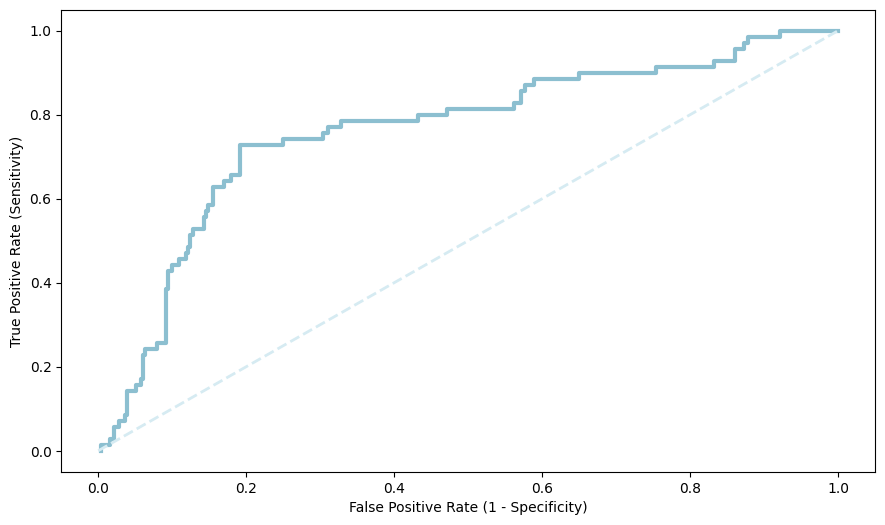

In [13]:
labels_and_scores = predict_test.select('sentiment', 'prediction')
labels_and_weights = labels_and_scores.collect()
labels_and_weights.sort(key=lambda x: x[1], reverse=True)
labels_by_weight = np.array([k for (k, v) in labels_and_weights])

length = labels_by_weight.size
true_positives = labels_by_weight.cumsum()
num_positive = true_positives[-1]
false_positives = np.arange(1.0, length + 1, 1.) - true_positives

true_positive_rate = true_positives / num_positive
false_positive_rate = false_positives / (length - num_positive)

# Generate layout and plot data
fig, ax = plt.subplots(figsize=(10.5, 6), facecolor='white', edgecolor='white')
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(false_positive_rate, true_positive_rate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model



#Evaluate model

#evaluation of the model
evaluator=BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="sentiment")
predict_test.select("sentiment","prediction","probability").show(truncate=False)


In [ ]:
def evaluate(predictionAndLabels):
    log = {}

    print("Training:\n Area Under ROC: " + str(trainingSummary.areaUnderROC))
    # Show Validation Score (AUROC)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['AUROC'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Testing:\nArea under ROC = {}".format(log['AUROC']))

    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['AUPR'] = "%f" % evaluator.evaluate(predictionAndLabels)
    print("Area under PR = {}".format(log['AUPR']))

    # Metrics
    predictionRDD = predictionAndLabels.select(['label', 'prediction']) \
                            .rdd.map(lambda line: (float(line[1]), float(line[0])))
    metrics = MulticlassMetrics(predictionRDD)

    # Confusion Matrix
    print(metrics.confusionMatrix().toArray())

    # Overall statistics
    log['precision'] = "%s" % metrics.precision()
    log['recall'] = "%s" % metrics.recall()
    log['F1 Measure'] = "%s" % metrics.fMeasure()
    print("[Overall]\tprecision = %s | recall = %s | F1 Measure = %s" % \
            (log['precision'], log['recall'], log['F1 Measure']))

    # Statistics by class
    labels = [0.0, 1.0]
    for label in sorted(labels):
        log[label] = {}
        log[label]['precision'] = "%s" % metrics.precision(label)
        log[label]['recall'] = "%s" % metrics.recall(label)
        log[label]['F1 Measure'] = "%s" % metrics.fMeasure(label,
                                                           beta=1.0)
        print("[Class %s]\tprecision = %s | recall = %s | F1 Measure = %s" \
                  % (label, log[label]['precision'],
                    log[label]['recall'], log[label]['F1 Measure']))

    return log
from pyspark.sql.functions import col
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
evaluate(predict_test.withColumnRenamed('sentiment', 'label'))

In [19]:
print(df_original)

DataFrame[ride_review: string, ride_rating: double, sentiment: int]
